In [ ]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt

import LE as le
import LP as lp
import iterative as iterative
import graph_vis as vis
import logger_creator

import graph_tools
import networkx as nx
import random

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/dash_bootstrap_components/_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [2]:
def make_directed_symmetric(G_undirected):
    G_directed = nx.DiGraph()
    G_directed.add_nodes_from(G_undirected.nodes())
    
    for u, v in G_undirected.edges():
        G_directed.add_edge(u, v)
        G_directed.add_edge(v, u)

    return G_directed

In [3]:
range_x = range(0, 5001, 200)

times_le = []
times_lp = []
times_iterative = []
cycles = []
amount_of_nodes = []


logger, handler = logger_creator.create_logger("benchmarking")

for num_nodes in range_x:
    print(num_nodes)

    small_world_graph = make_directed_symmetric(nx.watts_strogatz_graph(num_nodes, min(4, num_nodes), 0.1, seed=0))
    small_world_graph.remove_edges_from(random.sample(list(small_world_graph.edges()), int(len(small_world_graph.edges()) * 0.6)))
    delegation_graph = graph_tools.prepare_graph(small_world_graph.nodes(), small_world_graph.edges())
    delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
    delegations = graph_tools.invert_graph(delegations_orig)
    nodes = list(delegation_graph)

    amount_of_nodes.append(len(nodes))

    # Verify the solutions are equal
    powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
    powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
    powers_iter = iterative.iterate_delegations(delegations, nodes)


    if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-4 for k in powers_le):
        logger.error("Powers do not match")
        logger.error(f"LE: {powers_le}")
        logger.error(f"LP: {powers_lp}")
        print("Mismatching powers in LE and LP. Check the log file for details.")
        break

    for node in sinks_le:
        if (powers_lp[node] - powers_iter[node] < 0.01):
            continue
        else: 
            logger.error("Powers do not match")
            logger.error(f"LP: {powers_lp}")
            logger.error(f"Iterative: {powers_iter}")
            print("Mismatching powers in LP and Iterative. Check the log file for details.")
            break


    G = graph_tools.dict_to_nx_graph(delegations_orig)
    num_cycles = len(list(nx.simple_cycles(G)))
    cycles += [num_cycles]

    n = 20
    # if 0 <= num_nodes < 500:
    #     n = 10
    # elif 500 <= num_nodes < 1000:
    #     n = 100
    # elif num_nodes < 2000:
    #     n = 100

    # LE
    le_model = le.set_up(delegations, nodes)
    start_time = time.time()
    for _ in range(n):
        le.solve(*le_model)
    end_time = time.time()
    
    times_le.append((end_time - start_time) / n)

    # LP
    lp_model = lp.set_up(delegations, nodes)
    start_time = time.time()
    for _ in range(n):
        lp.solve(*lp_model)
    end_time = time.time()

    times_lp.append((end_time - start_time) / n)

    # Iterative
    start_time = time.time()
    for _ in range(n):
        p = iterative.iterate_delegations(delegations, nodes)
    end_time = time.time()

    times_iterative.append((end_time - start_time) / n)



logger.removeHandler(handler)
handler.close()

print("Average number of cycles: ", sum(cycles) / len(cycles))

0
200
400
600
800


KeyboardInterrupt: 

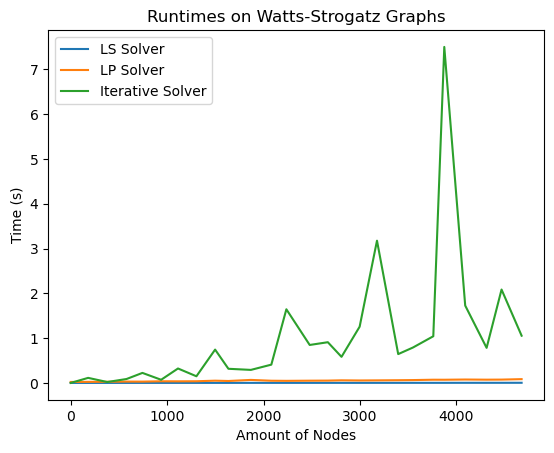

In [ ]:
x = amount_of_nodes

plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
plt.plot(x, times_iterative, label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes on Watts-Strogatz Graphs")
plt.show()

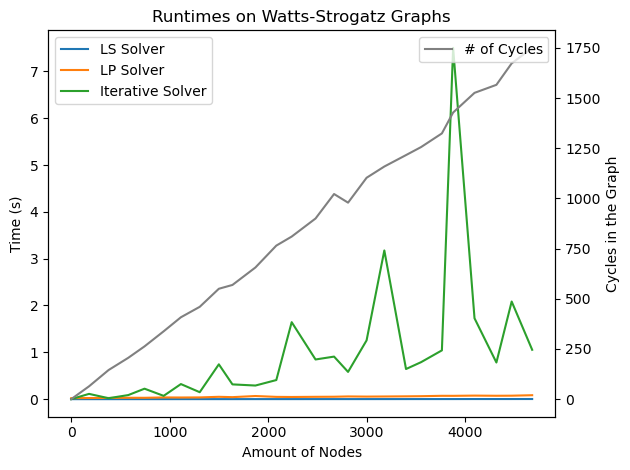

In [11]:
fig, ax1 = plt.subplots()

# Primary y-axis: runtimes
ax1.plot(x, times_le, label="LS Solver")
ax1.plot(x, times_lp, label="LP Solver")
ax1.plot(x, times_iterative, label="Iterative Solver")
ax1.set_xlabel("Amount of Nodes")
ax1.set_ylabel("Time (s)")
ax1.set_title("Runtimes on Watts-Strogatz Graphs")

# Add legend for primary axis
ax1.legend(loc='upper left')

# Secondary y-axis: number of collapsed cycles
ax2 = ax1.twinx()
ax2.plot(x, cycles, color='gray', label="# of Cycles")
ax2.set_ylabel("Cycles in the Graph")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


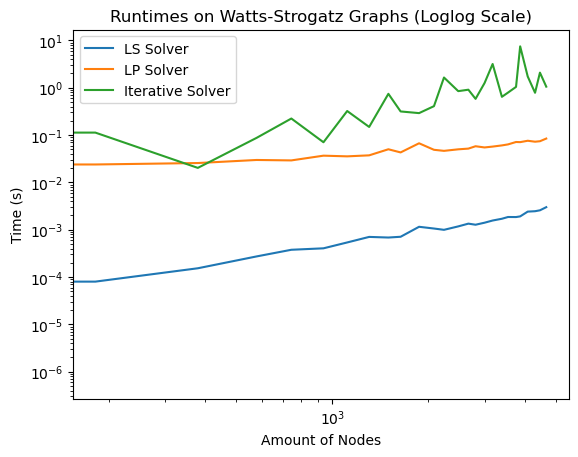

In [12]:
x = amount_of_nodes

plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
plt.plot(x, times_iterative, label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes on Watts-Strogatz Graphs (Loglog Scale)")
plt.loglog()
plt.show()

In [ ]:
print("x = ", x)
print("times_iterative = ", times_iterative)
print("times_le = ", times_le)
print("times_lp = ", times_lp)
print("cycles = ", cycles)

x =  [0, 178, 367, 568, 738, 940, 1112, 1342, 1484, 1686, 1872, 2085, 2232, 2398, 2638, 2783, 2987, 3171, 3335, 3582, 3743, 3910, 4106, 4328, 4449, 4654]
times_iterative =  [0.0001383066177368164, 0.011613702774047852, 0.028284382820129395, 0.047256088256835936, 0.048823308944702146, 0.2853456974029541, 0.1328641176223755, 0.1706325054168701, 0.3633159875869751, 0.21277530193328859, 0.4473644018173218, 0.6703860998153687, 0.3899833679199219, 0.4627676963806152, 1.0523023843765258, 2.6100072145462034, 1.0743979930877685, 0.79793860912323, 1.2426302194595338, 1.3672694206237792, 0.9614797115325928, 0.968317174911499, 0.4109076976776123, 0.5939031124114991, 4.469185471534729, 1.4740801095962524]
times_le =  [7.390975952148438e-07, 8.072853088378907e-05, 0.00019690990447998046, 0.0003414154052734375, 0.0003262042999267578, 0.00046839714050292967, 0.000514984130859375, 0.0007353067398071289, 0.0006465911865234375, 0.0007388830184936523, 0.0008458137512207031, 0.000941014289855957, 0.0009687

# Investigating smaller graphs more closely

In [ ]:
range_x = range(0, 20, 1)

times_le = []
times_lp = []
times_iterative = []
cycles = []
amount_of_nodes = []


logger, handler = logger_creator.create_logger("benchmarking")

for num_nodes in range_x:
    print(num_nodes)

    small_world_graph = make_directed_symmetric(nx.watts_strogatz_graph(num_nodes, min(4, num_nodes), 0.1, seed=0))
    small_world_graph.remove_edges_from(random.sample(list(small_world_graph.edges()), int(len(small_world_graph.edges()) * 0.6)))
    delegation_graph = graph_tools.prepare_graph(small_world_graph.nodes(), small_world_graph.edges())
    delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
    delegations = graph_tools.invert_graph(delegations_orig)
    nodes = list(delegation_graph)

    amount_of_nodes.append(len(nodes))

    # Verify the solutions are equal
    powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
    powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
    powers_iter = iterative.iterate_delegations(delegations, nodes)


    if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-4 for k in powers_le):
        logger.error("Powers do not match")
        logger.error(f"LE: {powers_le}")
        logger.error(f"LP: {powers_lp}")
        print("Mismatching powers in LE and LP. Check the log file for details.")
        break

    for node in sinks_le:
        if (powers_lp[node] - powers_iter[node] < 0.01):
            continue
        else: 
            logger.error("Powers do not match")
            logger.error(f"LP: {powers_lp}")
            logger.error(f"Iterative: {powers_iter}")
            print("Mismatching powers in LP and Iterative. Check the log file for details.")
            break


    G = graph_tools.dict_to_nx_graph(delegations_orig)
    num_cycles = len(list(nx.simple_cycles(G)))
    cycles += [num_cycles]

    n = 20
    # if 0 <= num_nodes < 500:
    #     n = 10
    # elif 500 <= num_nodes < 1000:
    #     n = 100
    # elif num_nodes < 2000:
    #     n = 100

    # LE
    le_model = le.set_up(delegations, nodes)
    start_time = time.time()
    for _ in range(n):
        le.solve(*le_model)
    end_time = time.time()
    
    times_le.append((end_time - start_time) / n)

    # LP
    lp_model = lp.set_up(delegations, nodes)
    start_time = time.time()
    for _ in range(n):
        lp.solve(*lp_model)
    end_time = time.time()

    times_lp.append((end_time - start_time) / n)

    # Iterative
    start_time = time.time()
    for _ in range(n):
        p = iterative.iterate_delegations(delegations, nodes)
    end_time = time.time()

    times_iterative.append((end_time - start_time) / n)

logger.removeHandler(handler)
handler.close()

print("Average number of cycles: ", sum(cycles) / len(cycles))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Average number of cycles:  3.4


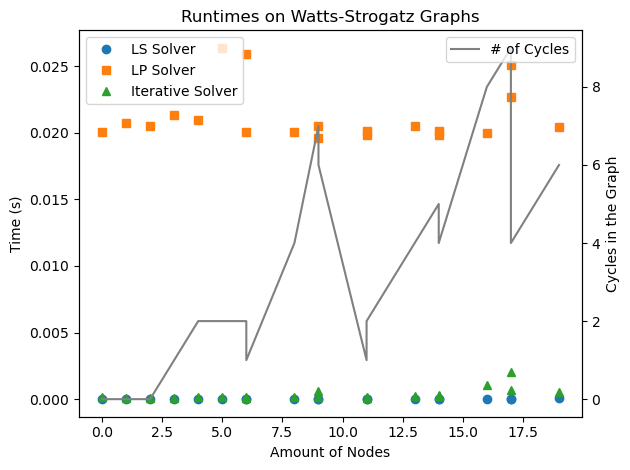

In [46]:
x = amount_of_nodes
fig, ax1 = plt.subplots()

# Primary y-axis: runtimes
ax1.plot(x, times_le, 'o', label="LS Solver", linestyle='None')
ax1.plot(x, times_lp, 's', label="LP Solver", linestyle='None')  # squares
ax1.plot(x, times_iterative, '^', label="Iterative Solver", linestyle='None')  # triangles
ax1.set_xlabel("Amount of Nodes")
ax1.set_ylabel("Time (s)")
ax1.set_title("Runtimes on Watts-Strogatz Graphs")

# Add legend for primary axis
ax1.legend(loc='upper left')

# Secondary y-axis: number of collapsed cycles
ax2 = ax1.twinx()
ax2.plot(x, cycles, color='gray', label="# of Cycles")
ax2.set_ylabel("Cycles in the Graph")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [44]:
x

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 10,
 15,
 16,
 15,
 18,
 19,
 20,
 21,
 17,
 23,
 24,
 25,
 26,
 27,
 28,
 27,
 27,
 29,
 26,
 31,
 33,
 35,
 35,
 35,
 37,
 36,
 34,
 40,
 42,
 43,
 44,
 41,
 45,
 47,
 46,
 46]

# Bigger graphs

In [ ]:
# range_x = range(0, 50001, 5000)

# logger, handler = logger_creator.create_logger("benchmarking")


# times_le = []
# times_lp = []
# times_iterative = []

# for num_nodes in range_x:
#     print(num_nodes)

#     small_world_graph = make_directed_symmetric(nx.watts_strogatz_graph(num_nodes, min(4, num_nodes), 0.2, seed=0))
#     delegation_graph = graph_tools.prepare_graph(small_world_graph.nodes(), small_world_graph.edges())
#     delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
#     delegations = graph_tools.invert_graph(delegations_orig)
#     nodes = list(delegation_graph)


#     # Verify the solutions are equal
#     powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
#     powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
#     powers_iter = iterative.iterate_delegations(delegations, nodes)

#     if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-6 for k in powers_le):
#         logger.error("Powers do not match")
#         logger.error(f"LE: {powers_le}")
#         logger.error(f"LP: {powers_lp}")
#         print("Mismatching powers in LE and LP. Check the log file for details.")
#         break

#     for node in sinks_le:
#         if (powers_lp[node] - powers_iter[node] < 0.01):
#             continue
#         else: 
#             logger.error("Powers do not match")
#             logger.error(f"LP: {powers_lp}")
#             logger.error(f"Iterative: {powers_iter}")
#             print("Mismatching powers in LP and Iterative. Check the log file for details.")
#             break

#     n = 20
#     if 0 <= num_nodes < 500:
#         n = 100
#     elif 500 <= num_nodes < 1000:
#         n = 100
#     elif num_nodes < 2000:
#         n = 100

#     # LE
#     le_model = le.set_up(delegations, nodes)
#     start_time = time.time()
#     for _ in range(n):
#         le.solve(*le_model)
#     end_time = time.time()
    
#     times_le.append((end_time - start_time) / n)

#     # LP
#     lp_model = lp.set_up(delegations, nodes)
#     start_time = time.time()
#     for _ in range(n):
#         lp.solve(*lp_model)
#     end_time = time.time()

#     times_lp.append((end_time - start_time) / n)

#     # Iterative
#     start_time = time.time()
#     for _ in range(n):
#         p = iterative.iterate_delegations(delegations, nodes)
#     end_time = time.time()

#     times_iterative.append((end_time - start_time) / n)

# logger.removeHandler(handler)
# handler.close()

0
5000
10000
15000


KeyboardInterrupt: 

In [4]:
print("x = ", x)
print("times_iterative = ", times_iterative)
print("times_le = ", times_le)
print("times_lp = ", times_lp)

NameError: name 'x' is not defined

In [3]:
[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000]
time_data_iterative
[[7.841110229492187e-05, 0.024668550491333006, 0.06840565204620361, 0.10012719631195069, 0.13310564756393434, 0.1816759467124939, 0.2563818097114563, 0.3149769425392151, 0.416628360748291, 0.4345307588577271, 0.4990972876548767]]
time_data_le
[[4.291534423828125e-07, 0.0016574501991271974, 0.003264892101287842, 0.004422199726104736, 0.005685853958129883, 0.007070600986480713, 0.008528995513916015, 0.010322988033294678, 0.011606597900390625, 0.012919759750366211, 0.013595247268676757]]
time_data_lp
[[0.019964978694915772, 0.07614328861236572, 0.13460885286331176, 0.18973571062088013, 0.2513334035873413, 0.33270504474639895, 0.372507643699646, 0.44359976053237915, 0.511565899848938, 0.5725200414657593, 0.6558308959007263]]

NameError: name 'time_data_iterative' is not defined

In [1]:
x = list(range_x)

plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
plt.plot(x, times_iterative, label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes on Watts-Strogatz Graphs")
plt.show()

NameError: name 'range_x' is not defined

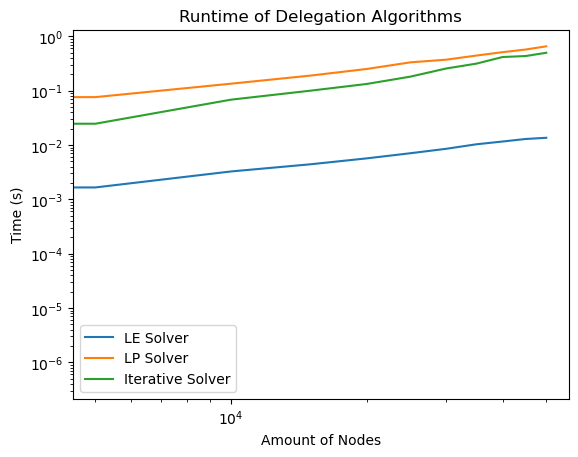

In [ ]:
x = list(range_x)

plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
plt.plot(x, times_iterative, label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes on Watts-Strogatz Graphs (Loglog scale)")
plt.loglog()
plt.show()

In [ ]:
x = list(range_x)

plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
plt.plot(x, times_iterative, label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes on R-Mat Delegation Graphs (Loglog Scale)")
plt.loglog()
plt.show()

# Visualization of an Example Graph


In [56]:
num_nodes = 25

small_world_graph = make_directed_symmetric(nx.watts_strogatz_graph(num_nodes, min(4, num_nodes), 0.1, seed=0))
small_world_graph.remove_edges_from(random.sample(list(small_world_graph.edges()), int(len(small_world_graph.edges()) * 0.6)))

In [57]:
delegation_graph = small_world_graph#graph_tools.prepare_graph(small_world_graph.nodes(), small_world_graph.edges())
delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
delegations = graph_tools.invert_graph(delegations_orig)
nodes = list(delegation_graph)

#powers, sinks = le.resolve_delegations(delegations, nodes)

viz.visualize_delegation_graph(delegations_orig)#, powers)

Parsing the data...Done


/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/jaal/datasets/parse_dataframe.py:42: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0' '1' '2' '2' '3' '3' '4' '4' '5' '6' '6' '6' '7' '7' '7' '8' '9' '10'
 '11' '11' '13' '13' '14' '14' '14' '15' '16' '17' '18' '19' '19' '20'
 '20' '21' '21' '22' '22' '22' '24' '24']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/jaal/datasets/parse_dataframe.py:42: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['24' '24' '3' '4' '1' '5' '2' '6' '7' '5' '7' '8' '5' '8' '20' '6' '11'
 '11' '10' '13' '14' '15' '12' '13' '15' '14' '18' '15' '16' '20' '21'
 '19' '21' '20' '22' '21' '23' '24' '0' '23']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/opt/anaconda3/envs/t

Graph visualization failed because no ports were found or there was another error.


No trigger


In [ ]:
# Testing how the small world graphs look like

num_nodes = 40

delegation_graph = graph_tools.prepare_graph(small_world_graph.nodes(), small_world_graph.edges())
delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
delegations = graph_tools.invert_graph(delegations_orig)
nodes = list(delegation_graph)

powers, sinks = le.resolve_delegations(delegations, nodes)

vis.visualize_delegation_graph(delegations_orig, powers)

Parsing the data...Done


/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/jaal/datasets/parse_dataframe.py:42: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0' '1' '2' '2' '4' '4' '5' '7' '7' '7' '8' '9' '10' '11' '11' '13' '13'
 '14' '14' '14' '15' '17' '19' '19' '20' '20' '21' '21' '22' '22' '22']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/jaal/datasets/parse_dataframe.py:42: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['24' '24' '3' '4' '2' '6' '7' '5' '8' '20' '6' '11' '11' '10' '13' '14'
 '15' '12' '13' '15' '14' '15' '20' '21' '19' '21' '20' '22' '21' '23'
 '24']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/jaal/datasets/parse_dataframe.py:57: FutureWa

Graph visualization failed because no ports were found or there was another error.


No trigger
